使用已有的少量数据从头开始训练一个新的模型  
1、在2000个训练样本上训练一个简单的小型卷积神经网络，不做任何正则化，为模型目标设定一个基准  
2、此时的主要问题是过拟合，通过使用数据增强(data augmentation)来降低网络的过拟合   
之后再5.3会介绍深度学习用于小型数据集的另外两个重要技巧:用预训练的网络做特征提取、对预训练的网络进行微调  

## 5.2.2 加载数据集
1、将图像复制到训练、验证、测试目录
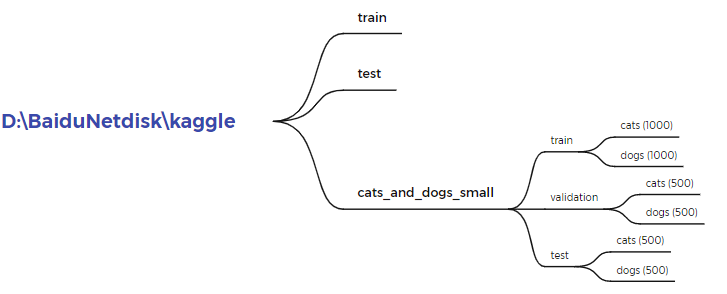

In [45]:
import os, shutil

#原始数据集解压的路径
original_dataset_dir = 'D:\\BaiduNetdisk\\kaggle\\train'

#保存小数据的目录
base_dir = 'D:\\BaiduNetdisk\\kaggle\\cats_and_dogs_small'
#os.mkdir(base_dir)

#分别对应划分后的训练、验证、测试目录
train_dir = os.path.join(base_dir, 'train')
#os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
#os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
#os.mkdir(test_dir)

#猫的训练目录
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

#狗的训练目录
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

#猫的验证目录
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

#狗的验证目录
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

#猫的测试目录
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

#狗的测试目录
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

#将前1000张猫的图像复制到train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
 
 #将接下来500张猫的图像复制到validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
 
 #将后500张猫的图像复制到test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

FileExistsError: [WinError 183] 当文件已存在时，无法创建该文件。: 'D:\\BaiduNetdisk\\kaggle\\cats_and_dogs_small\\train\\cats'

## 5.2.3 构建网络  
将猫狗分类的小型卷积神经网络实例化  
构建一个小型的卷积神经网络，即由Conv2D层和MaxPooling2D层堆叠而成  

In [46]:
from keras import layers, models

network = models.Sequential()
network.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (150, 150, 3)))
network.add(layers.MaxPooling2D(2, 2))
network.add(layers.Conv2D(64, (3,3), activation = 'relu'))
network.add(layers.MaxPooling2D(2, 2))
network.add(layers.Conv2D(128, (3,3), activation = 'relu'))
network.add(layers.MaxPooling2D(2, 2))
network.add(layers.Conv2D(128, (3,3), activation = 'relu'))
network.add(layers.MaxPooling2D(2, 2))

#将3D输出展平为1D
network.add(layers.Flatten())

#在net之后添加全连接层
network.add(layers.Dense(512, activation = 'relu'))
network.add(layers.Dense(1, activation = 'sigmoid'))

绘制构建的网络

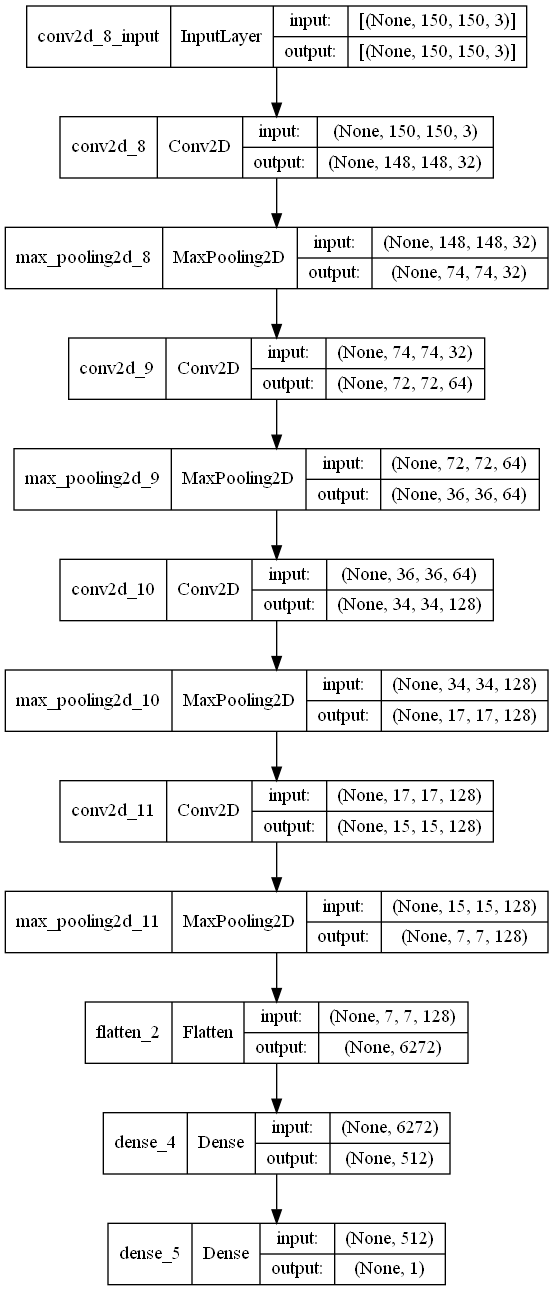

In [47]:
from tensorflow.keras.utils import plot_model

plot_model(network, show_shapes = True, to_file = 'cats and dogs.png')

In [48]:
network.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

**网络中特征图的深度在逐渐增加(从32增大到128)，而特征图的尺寸在逐渐减小(从150 * 150减小到7 * 7)，这几乎是所有卷积神经网络的模式**

3、配置模型用于训练

In [49]:
from tensorflow.keras import optimizers

network.compile(optimizer = optimizers.RMSprop(learning_rate = 1e-4),
                loss = 'binary_crossentropy', 
                metrics = ['accuracy'])

## 5.2.4 数据预处理  
在数据输入神经网络之前，应该将数据预处理化为浮点数张量  
数据预处理的大致步骤：  
*  (1) 读取图像文件  
   (2) 将JPEG文件解码为RGB像素网格  
   (3) 将这些像素网格转换为浮点张量  
   (4) 将这些像素值缩放到[0, 1]区间 

### Keras中有一个图像处理辅助工具的模块，位于tensorflow.keras.preprocessing.image，它包含ImageDataGenerator类，可以快速创建Python生成器，能够让硬盘上的图像文件快速转换为预处理好的张量批量  

In [50]:
#使用ImageDataGenerator从目录中读取图像
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#将所有图像进行缩放
train_datagen = ImageDataGenerator(rescale = 1.0 / 255)
validation_datagen = ImageDataGenerator(rescale = 1.0 / 255)
test_datagen = ImageDataGenerator(rescale = 1.0 / 255)

#train_dir目标目录，target_size调整后图像的大小，batch_size批大小，class_mode分类的模式
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size = (150, 150), 
                                                    batch_size = 20, 
                                                    class_mode = 'binary')

validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size = (150, 150),
                                                    batch_size = 20, class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(test_dir, target_size = (150, 150),
                                                  batch_size = 20, class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [51]:
#查看其中一个生成器的输出
for data_batch, labels_batch in train_generator:
    print(f"data batch size : {data_batch.shape}")
    print(f"labels batch size : {labels_batch.shape}")
    break

data batch size : (20, 150, 150, 3)
labels batch size : (20,)


5、利用批量生成器拟合模型  
利用生成器让模型对数据进行拟合，使用fit_generator方法进行拟合  
因为数据是不断生成的，所以模型需要知到每一轮从生成器中抽取多少个样本  
* steps_per_epoch:从生成器中抽取steps_per_epoch个批量后，进入下一个epoch  
* validation_steps:从生成器中抽取validation_steps个批量用于评估

In [52]:
history = network.fit_generator(
    train_generator,
    steps_per_epoch = 100, #2000个训练样本，每一批训练样本有20张图片，所以steps_per_epoch = 2000 / 20
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 50) #1000张验证图片，每一批验证图片有20张，所以validation_steps = 1000 / 20

<ipython-input-52-518c858af6b0>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = network.fit_generator(


Epoch 1/30
100/100 [==============================] - 52s 508ms/step - loss: 0.6888 - accuracy: 0.5245 - val_loss: 0.6814 - val_accuracy: 0.5170
Epoch 2/30
100/100 [==============================] - 53s 534ms/step - loss: 0.6578 - accuracy: 0.6165 - val_loss: 0.6672 - val_accuracy: 0.5520
Epoch 3/30
100/100 [==============================] - 58s 577ms/step - loss: 0.5949 - accuracy: 0.6840 - val_loss: 0.6221 - val_accuracy: 0.6460
Epoch 4/30
100/100 [==============================] - 42s 417ms/step - loss: 0.5611 - accuracy: 0.7080 - val_loss: 0.6061 - val_accuracy: 0.6690
Epoch 5/30
100/100 [==============================] - 27s 274ms/step - loss: 0.5381 - accuracy: 0.7320 - val_loss: 0.5913 - val_accuracy: 0.6890
Epoch 6/30
100/100 [==============================] - 27s 268ms/step - loss: 0.5052 - accuracy: 0.7430 - val_loss: 0.5763 - val_accuracy: 0.6940
Epoch 7/30
100/100 [==============================] - 27s 272ms/step - loss: 0.4766 - accuracy: 0.7770 - val_loss: 0.5615 - val_ac

6、保存模型

In [53]:
network.save('cats_and_dogs_small_1.h5')

7、绘制训练过程中的损失曲线和精度曲线

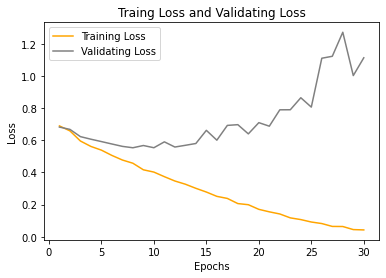

In [54]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'orange', label = "Training Loss")
plt.plot(epochs, val_loss, 'grey', label = "Validating Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Traing Loss and Validating Loss")

plt.legend()
plt.show()

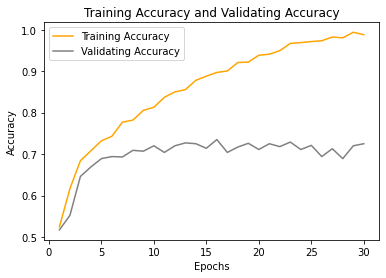

In [55]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, 'orange', label = "Training Accuracy")

plt.plot(epochs, val_accuracy, 'grey', label = "Validating Accuracy")

plt.title("Training Accuracy and Validating Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

In [56]:
#查看在训练过程中验证集上的最大精度
max(val_accuracy)

0.7350000143051147

In [57]:
#构建二分类矩阵
import numpy as np

#test_dir中一共有1000张图片，所以prediction的shape是(1000, 1)，labels的shape是(1000)
prediction = np.zeros(shape = (1000, 1))
labels = np.zeros(shape = (1000))

i = 0
batch_size = 20
#从test_generator中读取输入和标签，利用输入来得到prediction
for inputs_batch, labels_batch in test_generator:
    prediction_batch = network.predict(inputs_batch) 
    prediction[i * batch_size : (i+1) * batch_size] = prediction_batch
    labels[i * batch_size : (i+1) * batch_size]= labels_batch

    i += 1
    if i * batch_size >= 1000:
        break
        
prediction = [(int) ((p + 0.5) / 1) for p in prediction]
prediction = np.asarray(prediction).astype('float32')

#得到一个二分类的表格
import pandas as pd

pd.crosstab(labels, prediction ,rownames = ['labels'], colnames = ['predictions'])

predictions,0.0,1.0
labels,,
0.0,398,102
1.0,170,330


In [58]:
#查看分类报告
from sklearn.metrics import classification_report

print(classification_report(labels, prediction))

              precision    recall  f1-score   support

         0.0       0.70      0.80      0.75       500
         1.0       0.76      0.66      0.71       500

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000



## 5.2.5 使用数据增强
**过拟合的原因是学习样本太少，导致无法训练出能够泛化到新数据的模型。**  
如果有无限的数据，模型就能观察到数据分布的所有内容，这样就不会发生过拟合。  
**数据增强是从现有的数据中生成更多的训练数据，其方法是利用多种能够生成可信图像的随机变换来增加样本。让模型能够观察到更多的内容，从而具有良好的泛化能力。**

利用ImageDataGenerator来设置数据增强

In [59]:
?ImageDataGenerator #查看ImageDataGenerator使用说明

Object `ImageDataGenerator #查看ImageDataGenerator使用说明` not found.


In [60]:
#rotation_range图像随机旋转的范围0-180
#width_shift_range、height_shift_range图像在水平、垂直方向上平移的范围（相对于总宽度或总高度的比例）
#shear_range随机错切的变换角度，zoom_range图像随机缩放的范围
#horizontal_flip随机将一般的图像水平翻转
#fill_mode用与填充新像素的方法
datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

9、显示几个随机增强后的训练图像
os.listdir(train_cats_dir) : Return a list containing the names of the files in the directory.

In [61]:
from tensorflow.keras.preprocessing import image #图像预处理工具的模块

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

img_path = fnames[3] #选择一张图像进行增强

img = image.load_img(img_path, target_size = (150, 150)) #读取图像并调整大小

x = image.img_to_array(img) #将其转换为形状(150, 150, 3)的Numpy数组

In [62]:
x.shape

(150, 150, 3)

In [63]:
x = x.reshape((1, ) + x.shape) #将其形状改变为(1, 150, 150, 3)

In [64]:
x.shape

(1, 150, 150, 3)

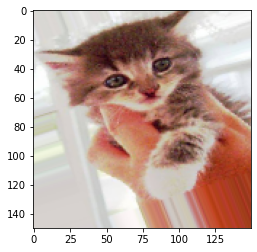

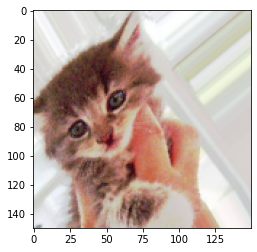

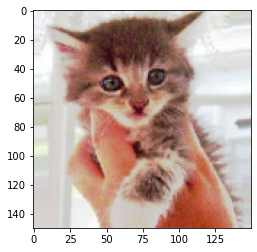

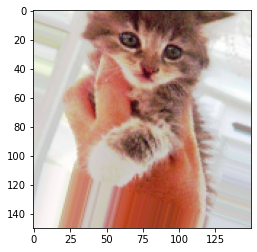

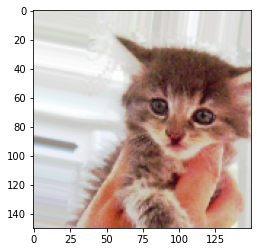

In [65]:
i = 0
#生成随机变换后的图像批量
for batch in datagen.flow(x, batch_size = 1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i%5 == 0:
        break
    plt.show()

10、定义一个包含dropout的新卷积神经网络

In [66]:
network_dropout = models.Sequential()

network_dropout.add(layers.Conv2D(32, (3, 3), activation = 'relu',input_shape = (150, 150, 3)))
network_dropout.add(layers.MaxPooling2D(2, 2))
network_dropout.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
network_dropout.add(layers.MaxPooling2D(2, 2))
network_dropout.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
network_dropout.add(layers.MaxPooling2D(2, 2))
network_dropout.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
network_dropout.add(layers.MaxPooling2D(2, 2))
network_dropout.add(layers.Flatten())
network_dropout.add(layers.Dropout(0.5)) #新添加的dropout层
network_dropout.add(layers.Dense(512, activation = 'relu'))
network_dropout.add(layers.Dense(1, activation = 'sigmoid'))

network_dropout.compile(optimizer = optimizers.RMSprop(learning_rate = 1e-4),
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

11、利用数据生成增强器来训练卷积神经网络

In [67]:
#在训练集上做数据增强
train_datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
    rotation_range = 40, 
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

In [68]:
#对于测试集，只需要对图像进行缩放
test_datagen = ImageDataGenerator(rescale = 1.0 / 255)

In [69]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size = (150, 150), 
    batch_size = 20, 
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size = (150, 150),
    batch_size = 20, 
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [70]:
history = network_dropout.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 50)

<ipython-input-70-351330d1b4b7>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = network_dropout.fit_generator(


Epoch 1/30
100/100 [==============================] - 71s 696ms/step - loss: 0.6940 - accuracy: 0.5180 - val_loss: 0.6905 - val_accuracy: 0.5340
Epoch 2/30
100/100 [==============================] - 69s 690ms/step - loss: 0.6896 - accuracy: 0.5345 - val_loss: 0.6859 - val_accuracy: 0.5410
Epoch 3/30
100/100 [==============================] - 70s 696ms/step - loss: 0.6799 - accuracy: 0.5525 - val_loss: 0.6713 - val_accuracy: 0.5750
Epoch 4/30
100/100 [==============================] - 72s 716ms/step - loss: 0.6653 - accuracy: 0.5975 - val_loss: 0.6564 - val_accuracy: 0.5940
Epoch 5/30
100/100 [==============================] - 71s 708ms/step - loss: 0.6539 - accuracy: 0.6185 - val_loss: 0.6357 - val_accuracy: 0.6190
Epoch 6/30
100/100 [==============================] - 72s 722ms/step - loss: 0.6373 - accuracy: 0.6210 - val_loss: 0.6141 - val_accuracy: 0.6630
Epoch 7/30
100/100 [==============================] - 70s 695ms/step - loss: 0.6254 - accuracy: 0.6475 - val_loss: 0.6184 - val_ac

12、保存模型

In [71]:
network.save('cats_and_dogs_small_2.h5')

13、绘制损失曲线和精度曲线

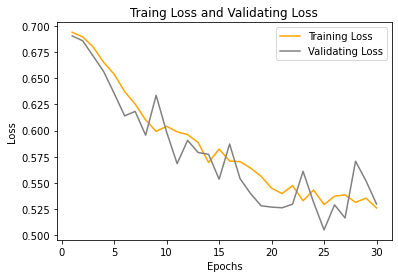

In [72]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'orange', label = "Training Loss")
plt.plot(epochs, val_loss, 'grey', label = "Validating Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Traing Loss and Validating Loss")

plt.legend()
plt.show()

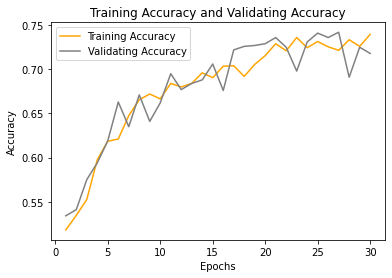

In [73]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, 'orange', label = "Training Accuracy")
plt.plot(epochs, val_accuracy, 'grey', label = "Validating Accuracy")

plt.title("Training Accuracy and Validating Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

In [74]:
max(val_accuracy)

0.7419999837875366

In [75]:
#构建二分类矩阵
import numpy as np

#test_dir中一共有1000张图片，所以prediction的shape是(1000, 1)，labels的shape是(1000)
prediction = np.zeros(shape = (1000, 1))
labels = np.zeros(shape = (1000))

i = 0
batch_size = 20
#从test_generator中读取输入和标签，利用输入来得到prediction
for inputs_batch, labels_batch in test_generator:
    prediction_batch = network.predict(inputs_batch) 
    prediction[i * batch_size : (i+1) * batch_size] = prediction_batch
    labels[i * batch_size : (i+1) * batch_size]= labels_batch

    i += 1
    if i * batch_size >= 1000:
        break
        
prediction = [(int) ((p + 0.5) / 1) for p in prediction]
prediction = np.asarray(prediction).astype('float32')

#得到一个二分类的表格
import pandas as pd

pd.crosstab(labels, prediction ,rownames = ['labels'], colnames = ['predictions'])

predictions,0.0,1.0
labels,,
0.0,398,102
1.0,170,330


In [76]:
#查看分类报告
from sklearn.metrics import classification_report

print(classification_report(labels, prediction))

              precision    recall  f1-score   support

         0.0       0.70      0.80      0.75       500
         1.0       0.76      0.66      0.71       500

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000

